# Data loading notebook for development / testing

In [1]:
using Pkg
Pkg.activate("/kuacc/users/ckorkmaz16/HiSD.jl/")

  Activating environment at `~/HiSD.jl/Project.toml`


In [2]:
using YAML: load_file
using Images, Interpolations
using Statistics

In [24]:
DATA_ROOT = "/kuacc/users/ckorkmaz16/HiSD_out"
CONFIG_FILE = "/kuacc/users/ckorkmaz16/HiSD.jl/configs/celeba-hq.yaml"

config = load_file(CONFIG_FILE)
println("Loaded config")

Loaded config


In [25]:
config["tags"]

3-element Vector{Dict{Any, Any}}:
 Dict("name" => "Bangs", "attributes" => Dict{Any, Any}[Dict("name" => "with", "filename" => "datasets/Bangs_with.txt"), Dict("name" => "without", "filename" => "datasets/Bangs_without.txt")], "tag_irrelevant_conditions_dim" => 2)
 Dict("name" => "Eyeglasses", "attributes" => Dict{Any, Any}[Dict("name" => "with", "filename" => "datasets/Eyeglasses_with.txt"), Dict("name" => "without", "filename" => "datasets/Eyeglasses_without.txt")], "tag_irrelevant_conditions_dim" => 2)
 Dict("name" => "HairColor", "attributes" => Dict{Any, Any}[Dict("name" => "black", "filename" => "datasets/HairColor_black.txt"), Dict("name" => "blond", "filename" => "datasets/HairColor_blond.txt"), Dict("name" => "brown", "filename" => "datasets/HairColor_brown.txt")], "tag_irrelevant_conditions_dim" => 2)

In [73]:
function load_image(path::String)
    return load(path) .|> RGB .|> float
end

function display_image(img)
    if length(size(img)) == 3
        if minimum(img) < 0.0
            img = img .* 0.5 .+ 0.5
        end
        return img .|> N0f8 |> colorview(RGB)
    else
        return img .|> RGB{N0f8}
    end
end

module Transformations

export Transformation, Identity, ToTensor, Compose

using Images, Interpolations
using Random
using Distributions

struct Resize
    size
    interpolation
    Resize(size, interpolation=BSpline(Linear())) = new(size, interpolation)
end
function (r::Resize)(x)
    if isa(r.size, Number)
        h, w = size(x)
        if (w <= h &&  w == r.size) || (h <= w && h == r.size)
            return x
        end

        oh, ow = if w < h
            Int(r.size * h / w), r.size
        else
           r.size, Int(r.size * w / h) 
        end
    else
        oh, ow = r.size
    end
    
    return imresize(x, (oh, ow), method=r.interpolation)
end

struct RandomCrop
    size
    RandomCrop(size::Number) = new((size, size))
    RandomCrop(size) = new(size)
end
function get_params(r::RandomCrop, x)
    h, w = size(x)
    th, tw = r.size
    if h == th && w == tw
        return 1, 1, h, w
    end

    i = rand(1:(h-th+1))
    j = rand(1:(w-tw+1))
    return i, j, th, tw
end
function (r::RandomCrop)(x)
    i, j, h, w = get_params(r, x)
    return x[i:i+h-1, j:j+w-1]
end

struct RandomHorizontalFlip
    prob
    RandomHorizontalFlip(prob=0.5) = new(prob)
end
function (r::RandomHorizontalFlip)(x)
    if rand() < r.prob
        x = x[:, end:-1:1]
    end
    return x
end

function to_tensor(x)
    return x |> channelview
end

struct Normalize
    mean
    std
    Normalize(mean, std) = new(mean, std)
end
(n::Normalize)(x) = (x .- n.mean) ./ n.std

function blend(im1, im2, alpha)
    return clamp.((1 - alpha) * im1 .+ alpha * im2, 0.0, 1.0)
end

function gray(img)
   return 0.299 * img[1, :, :] + 0.587 * img[2, :, :] + 0.114 * img[3, :, :]
end

function adjust_brightness(img, brightness_factor)
    return clamp.(brightness_factor * img, 0.0, 1.0)
end

function adjust_contrast(img, contrast_factor)
    degenerate = mean(gray(img))
    return blend(degenerate, img, contrast_factor)
end

function adjust_saturation(img, saturation_factor)
    degenerate = gray(img)
    return blend(reshape(degenerate, (1,size(degenerate)...)), img, saturation_factor)
end

function adjust_hue(img, hue_factor)
    img = img |> colorview(RGB) .|> HSV |> channelview
    scale = 360.0
    img[1, :, :] = mod.(img[1, :, :] .+ scale * hue_factor, scale)
    return img |> colorview(HSV) .|> RGB |> channelview
end

function get_jitter_param(value, name, center=1, clip_first_on_zero=true)
    @assert value >= 0 "$name must be non-negative"
    value = [center - value, center + value]
    if clip_first_on_zero
        value[1] = max(value[1], 0)
    end

    # if value is 0 or (1., 1.) for brightness/contrast/saturation
    # or (0., 0.) for hue, do nothing
    if value[1] == center && value[2] == center
        value = nothing
    end
    return value
end

struct ColorJitter
    brightness
    contrast
    saturation
    hue
    function ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
        brightness = get_jitter_param(brightness, "brightness")
        contrast = get_jitter_param(contrast, "contrast")
        saturation = get_jitter_param(saturation, "saturation")
        hue = get_jitter_param(hue, "hue", 0, false)
        new(brightness, contrast, saturation, hue)
    end
end
function (c::ColorJitter)(x)
    transforms = []
    if !isnothing(c.brightness)
        brightness_factor = rand(Uniform(c.brightness[1], c.brightness[2]))
        push!(transforms, img -> adjust_brightness(img, brightness_factor)) 
    end
    if !isnothing(c.contrast)
        contrast_factor = rand(Uniform(c.contrast[1], c.contrast[2]))
        push!(transforms, img -> adjust_contrast(img, contrast_factor)) 
    end
    if !isnothing(c.saturation)
        saturation_factor = rand(Uniform(c.saturation[1], c.saturation[2]))
        push!(transforms, img -> adjust_saturation(img, saturation_factor)) 
    end
    if !isnothing(c.hue)
        hue_factor = rand(Uniform(c.hue[1], c.hue[2]))
        push!(transforms, img -> adjust_hue(img, hue_factor)) 
    end
    shuffle!(transforms)
    img = x |> channelview
    img = Compose(transforms...)(img)
    return img |> colorview(RGB)
end

struct Compose
    transformations
    Compose(transformations...) = new(transformations)
end
(c::Compose)(x) = (for t in c.transformations; x = t(x); end; x)

end

Main.Transformations

In [6]:
config["new_size"], config["crop_image_height"], config["crop_image_width"]

(128, 128, 128)

(typeof(img), size(img)) = (Matrix{RGB{Float32}}, (128, 128))
(typeof(img_r), size(img_r)) = (Array{Float64, 3}, (3, 128, 128))


,

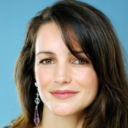
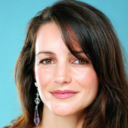

In [111]:
img = load_image("/kuacc/users/ckorkmaz16/HiSD_out/CelebA-HQ-img/3001.png")
@show typeof(img), size(img)
trans = Transformations.Compose(
    Transformations.ColorJitter(0.1, 0.1, 0.1, 0.1),
    Transformations.RandomHorizontalFlip(0.5),
    Transformations.to_tensor,
    Transformations.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
)
img_r = trans(img)
@show typeof(img_r), size(img_r)
display_image.([img, img_r])

In [130]:
module Data

using Images.FileIO

export ImageDataset, length

struct ImageData; filename::String; gender::Int; age::Int; end

function load(d::ImageData, transformation=nothing)
    image = FileIO.load(d.filename)
    conditions = [d.gender, d.age]
    if !isnothing(transformation)
        image = transformation(image)
    end
    return image, conditions
end

struct ImageDataset
    lines::Vector{ImageData}
    transformation

    function ImageDataset(root_dir::AbstractString, filename::AbstractString, transformation=nothing)
        path = joinpath(root_dir, filename)
        lines = readlines(path)
        lines = (rstrip(line) |> split for line in lines)
        new([ImageData(line[1], parse(Int, line[2]), parse(Int, line[3])) for line in lines], transformation)
    end
end

Base.length(d::ImageDataset) = length(d.lines)
function Base.iterate(d::ImageDataset, state=1)
    if state > length(d.lines)
        return nothing
    end
    return (() -> load(d.lines[state], d.transformation)), state+1
end
    
end

Main.Data

In [27]:
tags = config["tags"]
[[attrib["filename"] for attrib in tag["attributes"]] for tag in tags]

3-element Vector{Vector{String}}:
 ["datasets/Bangs_with.txt", "datasets/Bangs_without.txt"]
 ["datasets/Eyeglasses_with.txt", "datasets/Eyeglasses_without.txt"]
 ["datasets/HairColor_black.txt", "datasets/HairColor_blond.txt", "datasets/HairColor_brown.txt"]

In [131]:
# Note: original applies resize after flip
# However, Color Jitter with julia is too slow (or all functions requiring Images.jl conversions)
# Hence, I resize first at the cost of less accurate jitter
# This may create an actual difference in the final accuracy
# But on my benchmarks, it reduced total allocated memory size by 20x and reduced time by more than 2x
## ---
# To get even faster data times for faster training, I resized images beforehand and saved resized 128x128 versions instead of 1024x1024
transformation = Transformations.Compose(
    Transformations.ColorJitter(0.1, 0.1, 0.1, 0.1),
    Transformations.RandomHorizontalFlip(0.5),
    Transformations.to_tensor,
    Transformations.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
)
datasets = [[Data.ImageDataset(DATA_ROOT, attrib["filename"], transformation) for attrib in tag["attributes"]] for tag in tags] 
println("Loaded $(sum(length.(datasets))) datasets, with sizes $([length.(dataset) for dataset in datasets])")

Loaded 7 datasets, with sizes [[4857, 22143], [1378, 25622], [5894, 4203, 6015]]


In [132]:
datasets[1][1].lines[1].filename

"/kuacc/users/ckorkmaz16/HiSD_out/CelebA-HQ-img/3001.png"

In [133]:
function load_nth_images(n)
    take_one(d) = ((img, _) = Iterators.first(Iterators.drop(d, n))(); img)

    images = [take_one(datasets[1][1]), take_one(datasets[1][2]), 
        take_one(datasets[2][1]), take_one(datasets[2][2]),
        take_one(datasets[3][1]), take_one(datasets[3][2]), take_one(datasets[3][3])]
    return images
end


load_nth_images (generic function with 1 method)

In [134]:
load_nth_images(100); 

In [136]:
@time for i in 200:219; load_nth_images(i); end

  1.268028 seconds (24.31 k allocations: 770.221 MiB, 3.42% gc time)


,,,,,,

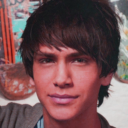
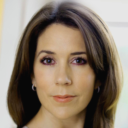
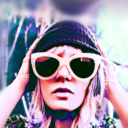
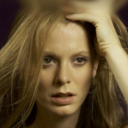
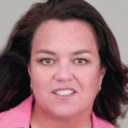
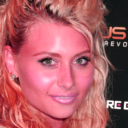
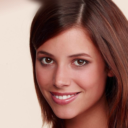

In [144]:
display_image.(load_nth_images(103))